In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGES_PATH = 'data/images/'

In [34]:
IMAGES_NAME = !ls ../data/images/
IMAGES_NAME.pop(1)
IMAGES_NAME

['barcode-00-01.jpg']

In [35]:
images = [io.imread('../' + IMAGES_PATH + image_name) for image_name in IMAGES_NAME]

In [36]:
images = [np.array(image).mean(axis=2).astype(np.uint8) for image in images]

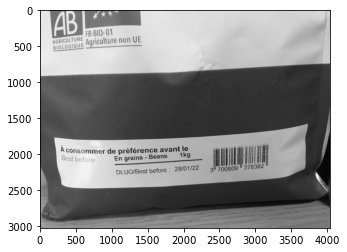

In [37]:
plt.imshow(images[0], cmap='gray')
plt.show()

In [38]:
all_tiles = []
for image in images:
    n_cols = len(image[0])
    n_rows = len(image)

    tiles = []

    for i in range(0, n_rows, 16):
        for j in range(0, n_cols, 16):
            tiles.append(image[i:i+16, j:j+16])
    all_tiles.append(tiles)

In [39]:
t = np.array(all_tiles)
t.shape

(1, 47628, 16, 16)

In [40]:
index_table = [(0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1)]
padding_row = np.zeros(18).astype(np.uint8).tolist()

In [41]:
def compute_lbp_value(lbp_window):
    lbp_value = 0
    pixel_value = lbp_window[1][1]
    for i in range(8):
        row_index, col_index = index_table[i]
        lbp_value = lbp_value | (int(lbp_window[row_index][col_index] >= pixel_value) << i)
        
    return lbp_value

In [42]:
def pad_tile(tile):
    tileList = tile.tolist()
    
    for i in range(16):
        tileList[i].insert(0, 0)
        tileList[i].append(0)
    tileList.insert(0, padding_row)
    tileList.append(padding_row)    
    return np.array(tileList)

In [56]:
all_histo = []
for tiles in all_tiles:
    histo_list = []
    for tile in tiles:
        padded_tile = pad_tile(tile)
        lbp_histo = [0 for i in range(256)]
    
        for i in range(1, 17):
            for j in range(1, 17):
                window = padded_tile[i-1:i+2, j-1:j+2]
                lbp_histo[compute_lbp_value(window)] += 1    
            
        histo_list.append(lbp_histo) #/ np.max(lbp_histo))
    
    all_histo.append(histo_list)
    

In [59]:
all_histo = np.array(all_histo)
all_histo.shape

(1, 47628, 256)

In [60]:
all_histo_reshaped = all_histo.reshape((-1, 256))

In [61]:
from sklearn.cluster import KMeans

In [62]:
n_cluster=16

In [69]:
kmeans = KMeans(n_clusters=n_cluster, random_state=128).fit(all_histo_reshaped)

In [70]:
kmeans.cluster_centers_.dtype

dtype('float64')

In [71]:
import pandas as pd

pd.DataFrame(kmeans.cluster_centers_).to_csv("../data/centroids.csv", header=None, index=None)

In [23]:
#To remove
transformed = kmeans.predict(histo1.reshape((-1, 256)))

In [24]:
# To remove
transformed_reshape = transformed.reshape(image.shape[0] // 16, image.shape[1] // 16)

In [23]:
# To remove
plt.imshow(transformed_reshape)

NameError: name 'transformed_reshape' is not defined

In [24]:
# Remove following cells

In [26]:
import matplotlib.cm as cm


In [27]:
def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)  # take n_values values between 0 and 1 (evenly spaced)
    rng = np.random.default_rng(3)  # get a RNG with a specific seed
    samples = rng.permutation(samples)  # shuffle our values
    colors = cm.hsv(samples, alpha=None, bytes=True)  # get corresponding colors from the HSV color map
    return colors[...,:3]  # remove alpha channel and return

In [28]:
lut = random_lut(n_cluster)

In [29]:
recolored = lut[transformed_reshape]
recolored.shape

(189, 252, 3)

In [30]:
def show_image_seg(img, recolored, n_clusters):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original image")
    plt.subplot(1,2,2)
    plt.imshow(recolored)
    plt.title(f"Segmented areas (with spatial info), {n_clusters} clusters")

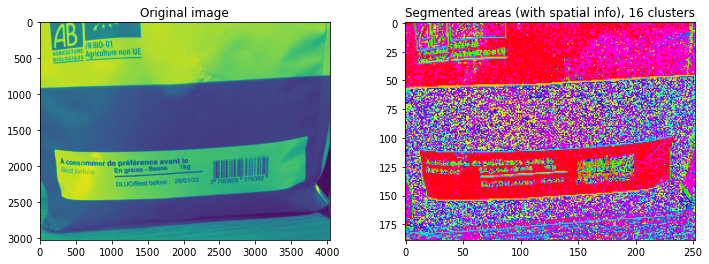

In [31]:
show_image_seg(images[0], recolored, n_cluster)

In [ ]:
# Output n_centers to file